In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

#Load and Filter Dataset
df = pd.read_csv("Project/reddit_labeled.csv")
df = df[df["label"].isin([
    "neutral", "academic_stress", "relationship_issues",
    "existential_crisis", "social_isolation"
])]

#Split Data
X = df["clean_text"].astype(str)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

#Train SVM Classifier
svm_clf = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
svm_clf.fit(X_train_vec, y_train)

#Predictions
y_pred = svm_clf.predict(X_test_vec)

#Classification Report
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

#Accuracy
acc = accuracy_score(y_test, y_pred)
print(f" Overall Accuracy: {acc:.4f}")


 Classification Report:

                     precision    recall  f1-score   support

    academic_stress     0.9115    0.7230    0.8063       527
 existential_crisis     0.2000    0.0556    0.0870        18
            neutral     0.6702    0.7917    0.7259       480
relationship_issues     0.6335    0.6866    0.6590       501
   social_isolation     0.6000    0.2500    0.3529        12

           accuracy                         0.7211      1538
          macro avg     0.6030    0.5014    0.5262      1538
       weighted avg     0.7349    0.7211    0.7213      1538

 Overall Accuracy: 0.7211


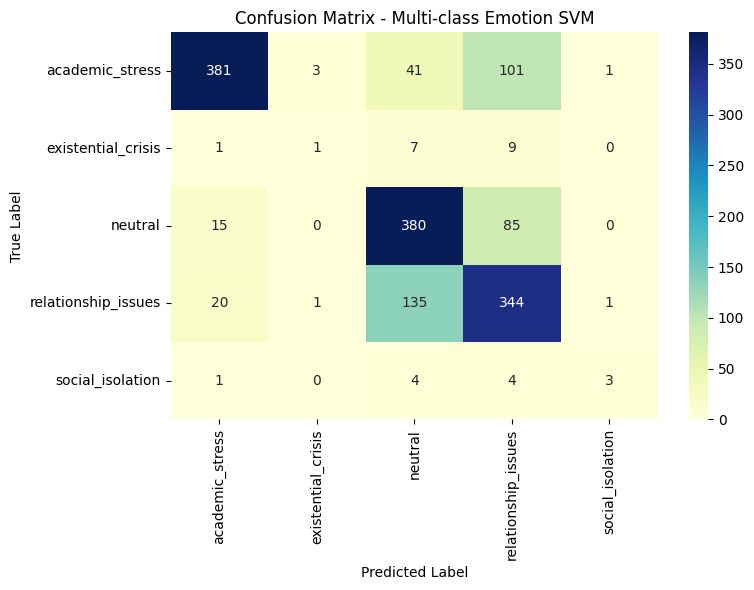

SVM Model + Vectorizer saved to: Project/Models/SVM_Multiclass/


In [2]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=svm_clf.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=svm_clf.classes_,
            yticklabels=svm_clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Multi-class Emotion SVM")
plt.tight_layout()
plt.show()

#Save Model and Vectorizer ───────────────────────────────────
os.makedirs("Project/Models/SVM_Multiclass", exist_ok=True)
joblib.dump(svm_clf, "Project/Models/SVM_Multiclass/emotion_svm_classifier.joblib")
joblib.dump(tfidf,   "Project/Models/SVM_Multiclass/tfidf_vectorizer.joblib")

print("SVM Model + Vectorizer saved to: Project/Models/SVM_Multiclass/")

In [5]:
# ─── Load Model and Vectorizer ─────────────────────────────
import joblib

svm = joblib.load("Project/Models/SVM_Multiclass/emotion_svm_classifier.joblib")
tfidf = joblib.load("Project/Models/SVM_Multiclass/tfidf_vectorizer.joblib")

# ─── Map Labels to Severity ────────────────────────────────
INTENSITY_LEVELS = {
    "neutral": 0.00,
    "social_isolation": 0.25,
    "relationship_issues": 0.50,
    "academic_stress": 0.75,
    "existential_crisis": 1.00
}

# ─── Predict Function ──────────────────────────────────────
def predict_emotion_with_intensity(text):
    vec = tfidf.transform([text])
    pred = svm.predict(vec)[0]
    intensity = INTENSITY_LEVELS.get(pred, -1)  # -1 if unknown label
    return pred, intensity

# ─── Example ───────────────────────────────────────────────
sample = "My partner broke up"
label, score = predict_emotion_with_intensity(sample)

print(f"Predicted Emotion: {label}")
print(f"Severity Level: {score}")

Predicted Emotion: relationship_issues
Severity Level: 0.5
